## Package needed to read SSD and some other funtions 

In [1]:
using Plots
using SpecialFunctions
using Unitful, UnitfulAtomic
using HDF5, CSV, DataFrames
using LegendHDF5IO
using SolidStateDetectors
using ImageFiltering, Noise, DSP, RadiationDetectorSignals
using Random, Distributions,StatsBase, LinearAlgebra
using GePixDet
T = Float32;

┌ Info: Precompiling GePixDet [2a75a1f9-153c-4a32-8ddb-946bc121a9ac]
└ @ Base loading.jl:1423


In [2]:
ssd_sim_result=ssd_read("/nfs/tegile/work/experiences/detecteurs/manzanillas/SSD/soleil_diamond_batch.h5", Simulation)

┌ Warning: Stored simulation does not have a field for `imp_scale` (impurity scale) as this was 
│ first introduced in SolidStateDetectors.jl v0.8 for improved depletion handling.
│ It is advised to recalculate the simulation with the latest version.
│ The field `imp_scale` is determined from `point_types`: 
│     * undepleted point -> imp_scale = 0;  
│     * depleted point -> imp_scale = 1;  
└ @ SolidStateDetectors /home/experiences/detecteurs/manzanillas/.julia/packages/SolidStateDetectors/S2T6X/src/Simulation/Simulation.jl:92


Simulation{Float32, Cartesian} - Coordinate system: Cartesian
  Environment Material: Vacuum
  Detector: Diamond-soleil
  Electric potential: (1250, 924, 348)
  Charge density: (1250, 924, 348)
  Impurity scale: (1250, 924, 348)
  Fix Charge density: (1250, 924, 348)
  Dielectric distribution: (1251, 925, 349)
  Point types: (1250, 924, 348)
  Electric field: (1250, 924, 348)
  Weighting potentials: 
    Contact 1: (350, 326, 240)
    Contact 2: (376, 316, 240)
    Contact 3: (286, 288, 234)
    Contact 4: (360, 304, 236)
    Contact 5: (286, 288, 234)
    Contact 6: (378, 316, 240)
    Contact 7: (350, 328, 240)
    Contact 8: (294, 290, 236)
    Contact 9: (348, 326, 240)
    Contact 10: (378, 316, 240)
    Contact 11: (286, 288, 234)
    Contact 12: (356, 302, 236)
    Contact 13: (288, 286, 234)
    Contact 14: (376, 314, 240)
    Contact 15: (350, 326, 240)
    Contact 16: (284, 294, 234)
    Contact 17: (346, 336, 238)
    Contact 18: (298, 290, 234)
    Contact 19: (348, 336, 23

In [3]:
#define a grid in the region of interest for a fixed z
y_pos = collect(-0.006:0.0001:0.006)
x_pos = collect(-0.006:0.0001:0.006)
z_pos = 0.00193
#Define some variables to save information about rising time, collected charge and others
t_rising = []
pixel_charge = []
pixels_hitted = []
pixel_hit = []
#Simulate energy deposits of 20 keV
Energy = T[20] * u"keV"
#Need to define a time step to simulate the e-/hole propagation and waveform generation
time_step = 4u"ns"

4 ns

In [4]:
#Loop over each position of the grid and get the info
for posx in x_pos
    r_t = 0
    pixels = 0
    for posy in y_pos
        starting_positions = [ CartesianPoint{T}( posx, posy, z_pos )]
        evt = Event(starting_positions, Energy);
        charge = 1u"e_au"
        try
            simulate!(evt, ssd_sim_result,Δt = time_step,diffusion = true, self_repulsion = true)
            wfs_with_tail = add_baseline_and_extend_tail.(evt.waveforms[1:19],100,400)
            pixel_energies = trap_filter.(wfs_with_tail)
            pixel, charge, total, pixels = get_pixel_hitted(pixel_energies)
            #println("posx: ",posx," pixel: ",pixel," charge: ",charge)
            r_t =get_rising_time(wfs_with_tail[pixel],0.10,0.90)/u"ns"
            #println(r_t)
        catch
            r_t =-10.0
            charge = 1u"e_au"
        end
        push!(t_rising,r_t)
        push!(pixel_charge,charge/u"e_au")
        push!(pixels_hitted,pixels)
    end
end

In [5]:
datos_charge = hcat(map(n -> pixel_charge[(1:length(y_pos)).+n*length(y_pos)], 0:(length(x_pos)-1) )...)
datos_time = hcat(map(n -> t_rising[(1:length(y_pos)).+n*length(y_pos)], 0:(length(x_pos)-1) )...)

121×121 Matrix{Float64}:
 136.0  140.0  140.0  140.0  140.0  …  140.0  140.0  140.0  140.0  136.0
 140.0  136.0  140.0  136.0  140.0     140.0  140.0  140.0  140.0  136.0
 140.0  140.0  136.0  140.0  140.0     140.0  140.0  136.0  136.0  136.0
 136.0  136.0  136.0  136.0  140.0     140.0  136.0  136.0  136.0  136.0
 136.0  136.0  136.0  140.0  140.0     140.0  136.0  136.0  136.0  136.0
 132.0  132.0  136.0  136.0  140.0  …  140.0  136.0  136.0  136.0  136.0
 132.0  132.0  136.0  136.0  136.0     136.0  136.0  136.0  132.0  132.0
 132.0  132.0  132.0  136.0  136.0     132.0  132.0  132.0  132.0  132.0
 128.0  128.0  136.0  136.0  132.0     132.0  136.0  136.0  128.0  132.0
 128.0  132.0  132.0  132.0  132.0     132.0  132.0  132.0  128.0  128.0
 104.0  128.0  128.0  128.0  132.0  …  132.0  128.0  128.0  128.0  100.0
 100.0  100.0  128.0  132.0  128.0     128.0  128.0  132.0  100.0  104.0
 112.0  104.0  104.0  104.0  128.0     128.0  108.0  104.0  104.0  104.0
   ⋮                      

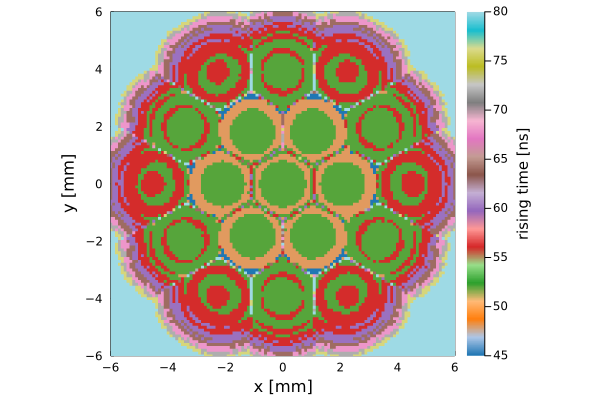

In [6]:
Plots.heatmap(x_pos*1000, y_pos*1000, datos_time,
    clims=(45,80),
    c=cgrad(:tab20),
    colorbar_title="rising time [ns]",
    aspect_ratio=:equal,
    framestyle = :box,
    xlims=(-6.0,6.0),
    ylims=(-6.0,6.0),
    xlabel="x [mm]", ylabel="y [mm]",
    title="")

## Electronics and amplification effects
- Need to measure baseline with detector for the electronics effects 
- Need to measure transfer funtion 
- For now use a simulated transfer function and electrnoics noise

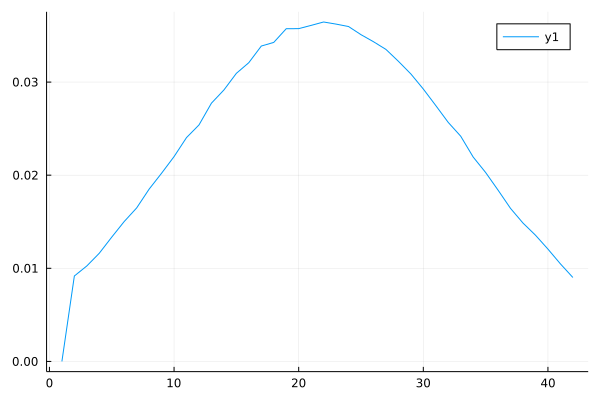

In [7]:
d = Normal(0,12)
x = rand(d, 10^6)
h = fit(Histogram, x, -20.5:1.0:20.5)
h_n=normalize(h, mode=:pdf)
transfer_function = vcat(zeros(1),h_n.weights[1:end])
Plots.plot(transfer_function)

In [8]:
x = LinRange(0.0, 1200, 1200)
y = zeros(1200);

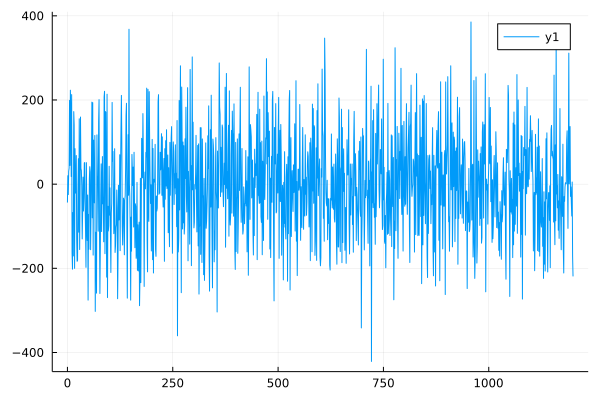

In [9]:
y_noise = add_gauss(y, 120)
Plots.plot(x,y_noise)

## Read and process a file with output from geant4

In [163]:
df = CSV.read("/nfs/tegile/work/experiences/detecteurs/manzanillas/DiamondSoleil/SimOutput/TestFileSSD00000.dat",  DataFrame, header=[:evt, :sample, :x, :y, :z, :E]);

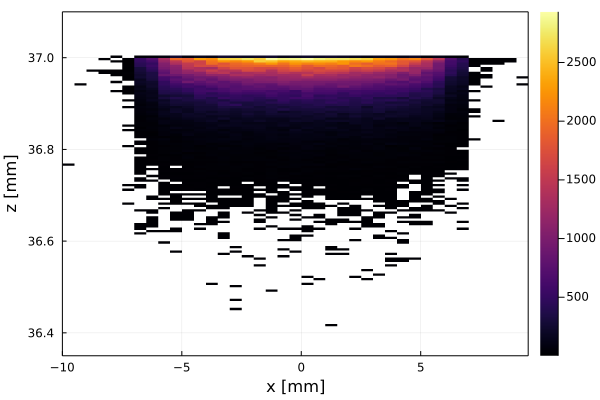

In [171]:
plot(df[!,:x],-df[!,:z],st=:hist2d,ylims=(36.35,37.1),framestyle = :box,label="",xlabel="x [mm]",ylabel="z [mm]")

In [130]:
shift_z = 35.0 #add 10 microns to avoid problems with events on the surface
rotation_z = -1
energy_tot = 0
event_coordinates = CartesianPoint{T}[]
event_energy = []
total_energy = []
time_step = 4u"ns"
t_rising = []
pixels_hitted = []
pixel_hit = []
hit_xyz = Array{T}(undef, 0, 3)
pixel_charge = []
event_number = df[1,:evt]
#for i=1:1:5000
for i=1:1:length(df[!,:evt])
    energy = df[i,:E]
    r_t = 0
    nPix = 0
    pixel = -1
    charge = 0
    chargePixel = 0
    z_coordinate = 0
    if df[i,:evt] == event_number 
        energy_tot += energy
        z_coordinate = df[i,:z]*rotation_z - shift_z
        hit_coordinates = CartesianPoint{T}(df[i,:x]/1000,df[i,:y]/1000,z_coordinate/1000)
        push!(event_coordinates,hit_coordinates)
        push!(event_energy,energy)
    else 
        push!(total_energy,energy_tot)
        E_event = event_energy*u"keV"
        evt = Event(event_coordinates, E_event);
        global hit_xyz = [hit_xyz; [df[i-1,:x] df[i-1,:y] df[i-1,:z]*rotation_z - shift_z]]
        #here code to compute rising time and others parameters using ssd 
        try
            simulate!(evt, ssd_sim_result,Δt = time_step,diffusion = false, self_repulsion = false)
            wfs_with_tail = add_baseline_and_extend_tail.(evt.waveforms[1:19],300,750)
            wfs_with_tail_amp = add_amplification.(wfs_with_tail,tuple(transfer_function))
            y_noise = add_gauss(y, 120)
            wfs_with_tail_amp_noise = add_electronics_noise.(wfs_with_tail_amp,tuple(y_noise))
            pixel_energies = trap_filter.(wfs_with_tail_amp_noise)
            pixel,chargePixel,charge,nPix = get_pixel_hitted(pixel_energies)
            r_t =get_rising_time(wfs_with_tail_amp_noise[pixel],0.10,0.90)/u"ns"
        catch
            r_t =-10.0
            charge = 0
        end
        push!(t_rising,r_t)
        push!(pixel_charge,chargePixel)
        push!(pixels_hitted,nPix)
        push!(pixel_hit,pixel)
        
        #reinitialize event and save energy and coordinates vector of the new event
        event_coordinates = CartesianPoint{T}[]
        event_energy = []
        z_coordinate = df[i,:z]*rotation_z - shift_z
        hit_coordinates = CartesianPoint{T}(df[i,:x]/1000,df[i,:y]/1000,z_coordinate/1000)
        push!(event_coordinates,hit_coordinates)
        push!(event_energy,energy)
        event_number = df[i,:evt]
        energy_tot = df[i,:E]
    end
end

┌ Warning: Handling of charge at floating boundary did not work as intended. Start Position (Cart): Float32[-0.00152832, 0.00986407, 0.0019902]
└ @ SolidStateDetectors /home/experiences/detecteurs/manzanillas/.julia/packages/SolidStateDetectors/S2T6X/src/ChargeDrift/ChargeDrift.jl:216
┌ Warning: Internal error for charge starting at Float32[-0.00152819, 0.00986441, 0.0019905]
└ @ SolidStateDetectors /home/experiences/detecteurs/manzanillas/.julia/packages/SolidStateDetectors/S2T6X/src/ChargeDrift/ChargeDrift.jl:226
┌ Warning: Handling of charge at floating boundary did not work as intended. Start Position (Cart): Float32[-0.00152845, 0.00986461, 0.0019905]
└ @ SolidStateDetectors /home/experiences/detecteurs/manzanillas/.julia/packages/SolidStateDetectors/S2T6X/src/ChargeDrift/ChargeDrift.jl:216
┌ Warning: Internal error for charge starting at Float32[-0.00323692, -0.000744756, 0.0019552]
└ @ SolidStateDetectors /home/experiences/detecteurs/manzanillas/.julia/packages/SolidStateDetecto

┌ Warning: Internal error for charge starting at Float32[0.00153061, -0.0029886, 0.0019735]
└ @ SolidStateDetectors /home/experiences/detecteurs/manzanillas/.julia/packages/SolidStateDetectors/S2T6X/src/ChargeDrift/ChargeDrift.jl:226
┌ Warning: Internal error for charge starting at Float32[0.00153074, -0.00298851, 0.0019735]
└ @ SolidStateDetectors /home/experiences/detecteurs/manzanillas/.julia/packages/SolidStateDetectors/S2T6X/src/ChargeDrift/ChargeDrift.jl:226
┌ Warning: Internal error for charge starting at Float32[-0.00112067, 0.0043021, 0.0019947]
└ @ SolidStateDetectors /home/experiences/detecteurs/manzanillas/.julia/packages/SolidStateDetectors/S2T6X/src/ChargeDrift/ChargeDrift.jl:226
┌ Warning: Handling of charge at floating boundary did not work as intended. Start Position (Cart): Float32[0.00855653, -0.00566429, 0.0019963]
└ @ SolidStateDetectors /home/experiences/detecteurs/manzanillas/.julia/packages/SolidStateDetectors/S2T6X/src/ChargeDrift/ChargeDrift.jl:216
┌ Warning: 

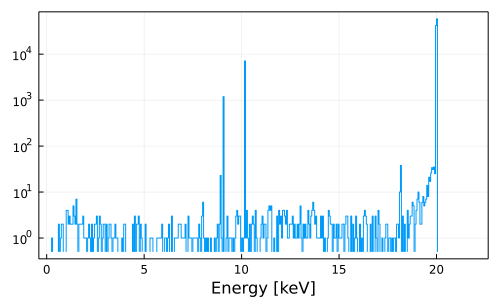

In [131]:
h_E = fit(Histogram, total_energy, 0:0.05:22)
Plots.plot(h_E,st=:step,framestyle = :box,label="",yscale=:log10,xlabel="Energy [keV]",size=(500,300))

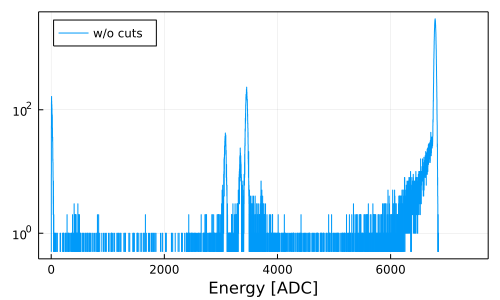

In [186]:
h_adc = fit(Histogram, pixel_charge, 0:1:7500)
Plots.plot(h_adc,st=:step,framestyle = :box,legend=:topleft,label="w/o cuts ",yscale=:log10,xlabel="Energy [ADC]",size=(500,300))

### Filter data 

In [184]:
filter_charge = []
for i=1:1:length(pixels_hitted)
    if pixels_hitted[i] > 1 || t_rising[i] > 150
        continue
    else
        push!(filter_charge,pixel_charge[i])
    end
end

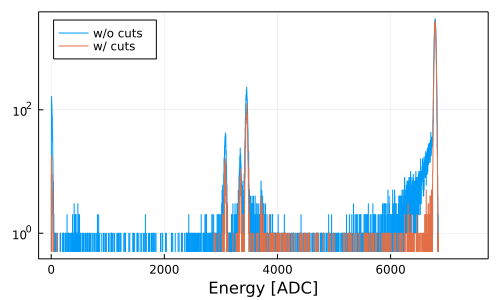

In [187]:
h_adc_filter = fit(Histogram, filter_charge, 0:1:7500)
Plots.plot!(h_adc_filter,st=:step,framestyle = :box,legend=:topleft,label="w/ cuts",yscale=:log10,xlabel="Energy [ADC]",size=(500,300))

### Plot example of waveforms with all effects included 

In [177]:
starting_positions = [ CartesianPoint{T}( 0.001, 0.000, 0.0019 )]
evt = Event(starting_positions, Energy);

In [178]:
simulate!(evt, ssd_sim_result,Δt = 4u"ns",diffusion = false, self_repulsion = false)
wfs_with_tail = add_baseline_and_extend_tail.(evt.waveforms[1:19],300,800)
wfs_with_tail_amp = add_amplification.(wfs_with_tail,tuple(transfer_function))
y_noise = add_gauss(y, 120)
wfs_with_tail_amp_noise = add_electronics_noise.(wfs_with_tail_amp,tuple(y_noise))
pixel_energies = trap_filter.(wfs_with_tail_amp_noise)
pixel,chargePixel,charge,nPix = get_pixel_hitted(pixel_energies)

(16, 6788.556588106817, 6788.556588106817, 1)

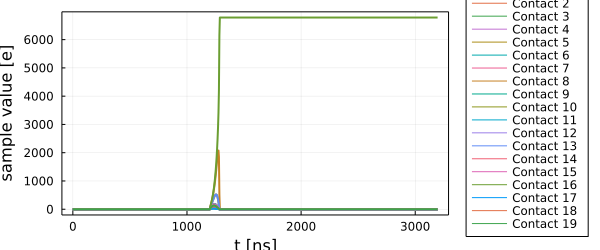

In [179]:
Plots.plot(wfs_with_tail[1:19],
      linewidth = 2, size = (600, 250), legend=:outerright, label = "Contact ".*string.((1:19)'), framestyle = :box)

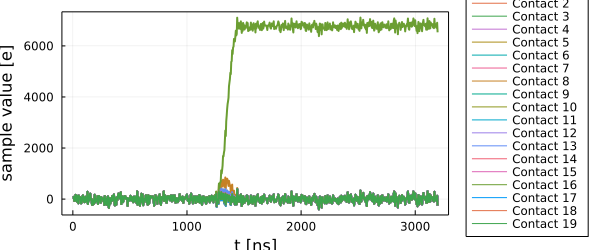

In [180]:
Plots.plot(wfs_with_tail_amp_noise[1:19],
      linewidth = 2, size = (600, 250), legend=:outerright, label = "Contact ".*string.((1:19)'), framestyle = :box)

In [181]:
tw = begin
   w = ones(Float64, 750)
   w[251:500] .= 0
   w[501:750] .= -1
   w
end
filter = filt(tw, (wfs_with_tail_amp_noise[pixel].value/u"e_au") / 250);

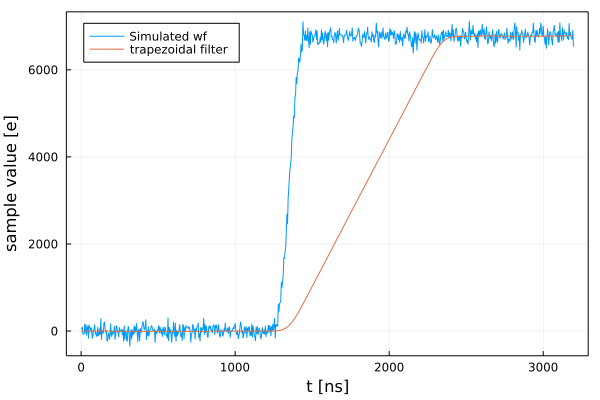

In [182]:
plot(wfs_with_tail_amp_noise[pixel],label="Simulated wf",legend=:topleft,framestyle = :box)
plot!(wfs_with_tail_amp_noise[pixel].time,filter,label="trapezoidal filter")

In [149]:
wfs_with_tail = add_baseline_and_extend_decay_tail.(evt.waveforms[1:19],300,800,5000.)
wfs_with_tail_amp = add_amplification.(wfs_with_tail,tuple(transfer_function))
y_noise = add_gauss(y, 120)
wfs_with_tail_amp_noise = add_electronics_noise.(wfs_with_tail_amp,tuple(y_noise))
result = trapezoidal_filter.(wfs_with_tail_amp_noise)
pixel,chargePixel,charge,nPix = get_pixel_hitted(result)

(16, 6090.109315430399, 6090.109315430399, 1)

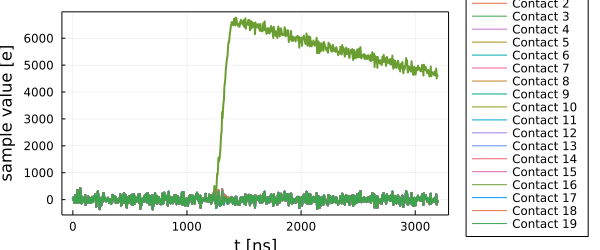

In [150]:
Plots.plot(wfs_with_tail_amp_noise[1:19],
      linewidth = 2, size = (600, 250), legend=:outerright, label = "Contact ".*string.((1:19)'), framestyle = :box)